This notebook contains the code of the most similar atlas (SIM) approach 

In [1]:
# Import libraries
from pathlib import Path
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pickle
import numpy as np 
import os
from tqdm import tqdm
import utils

from metadata import ImageDataset, patient

In [2]:
notebook_path = Path().cwd()
repo_path = notebook_path.parent
print(f'The current directory is: {notebook_path}')

The current directory is: d:\VS_Projects\MISA_FINAL_PROJECT\notebooks


In [3]:
#instantiate dataset, specify set name
img_training_data = ImageDataset('Training')
im_val_data = ImageDataset('Validation')

print(f'images paths: {img_training_data.im_paths()}')

#select one id of patient to check
id = img_training_data.IDs[0]
id_val = im_val_data.IDs[0]
print(f'selected id: {id}')
#istantiate patient object using the id and the previous ImageDataset object
pat = patient(id, img_training_data)
pat_val = patient(id_val, im_val_data)

# Get the image and the labels
im = pat.im()
labels = pat.labels()

im_val = pat_val.im()
labels_val = pat_val.labels()

images paths: ['data\\Training_Set\\IBSR_01\\IBSR_01.nii.gz', 'data\\Training_Set\\IBSR_03\\IBSR_03.nii.gz', 'data\\Training_Set\\IBSR_04\\IBSR_04.nii.gz', 'data\\Training_Set\\IBSR_05\\IBSR_05.nii.gz', 'data\\Training_Set\\IBSR_06\\IBSR_06.nii.gz', 'data\\Training_Set\\IBSR_07\\IBSR_07.nii.gz', 'data\\Training_Set\\IBSR_08\\IBSR_08.nii.gz', 'data\\Training_Set\\IBSR_09\\IBSR_09.nii.gz', 'data\\Training_Set\\IBSR_16\\IBSR_16.nii.gz', 'data\\Training_Set\\IBSR_18\\IBSR_18.nii.gz']
selected id: 01


In [6]:
def image_registration(fixedImage, movingImage):
    """Give two images and the registration of both, and its transformation map will be given

    Args:
        fixed_path (str): fixed (template) image
        moving_path (str): moving image (image that will be transformed)

    Returns:
        sitk image, transformix map: transformed image and the transformation map
    """

    #Start registration settings
    elastixImageFilter = sitk.ElastixImageFilter() #Image filter object
    #Defining settings
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)

    #Run registration
    elastixImageFilter.Execute()

    #Get result image
    resultImage = elastixImageFilter.GetResultImage()

    #Transformation map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    transformParameterMap[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformParameterMap[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]    
    transformParameterMap[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    return resultImage, transformParameterMap

### Registration and label propagation

In [7]:
# Create a folder to save the registered images
if not os.path.exists(repo_path / "data" / "registered_labels_all"):
    os.makedirs(repo_path / "data" / "registered_labels_all")

In [8]:
# for each training image, register it to the validation image
# In total of 50 registrations from 10 training images and 5 validation images
def save_registered_labels():
    '''Registers the training images to val images (training images= moving, val images=fixed image)
     It saves registered labels as pickle files.'''

    path_to_save_labels = repo_path / "data" / "registered_labels_all"

    list_labels_all = []
    for i in tqdm(range(len(img_training_data.IDs))):
        id = img_training_data.IDs[i]
        pat = patient(id, img_training_data)
        moving_image = pat.im(preprocess=True)
        labels = pat.labels()

        list_labels = []
        for v in range(len(im_val_data.IDs)):

            id_val = im_val_data.IDs[v]

            print(f'Registering training image {id} to validation image {id_val}...')

            pat_val = patient(id_val, im_val_data)
            fixed_image = pat_val.im(preprocess=True)
            labels_val = pat_val.labels()

            resultImage, transformParameterMap = image_registration(fixed_image, moving_image) #Register images using predefined transform map

            transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
            transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform
            transformixImageFilter.SetMovingImage(labels) #set labels as moving
            transformixImageFilter.Execute() #Tranform labels

            labels_registered = transformixImageFilter.GetResultImage() #Propagated labels

            with open(path_to_save_labels / f'trans_labels_{id}_to_{id_val}.p', 'wb') as handle:   #Save propagated labels as pickle file
                pickle.dump(labels_registered, handle, pickle.HIGHEST_PROTOCOL)

In [6]:
# read the transformed labels from the pickle files

path_to_save_labels = repo_path / "data" / "registered_labels_all"

# for each validation image, read the propagated labels from the pickle files
for v in range(len(im_val_data.IDs)):
    list_val=[]
    id_val = im_val_data.IDs[v]
    
    for i in tqdm(range(len(img_training_data.IDs))):
        id = img_training_data.IDs[i]
        
        # read the propagated labels from the pickle files
        with open(path_to_save_labels / f'trans_labels_{id}_to_{id_val}.p', 'rb') as handle: 
            list_labels= pickle.load(handle)
            list_val.append(list_labels)
            #is it necessary to save it?
    #         #to save all the propagated labels in one file per each validation image. (in total 5 different files)
    # with open(repo_path / "data" / f'all_trans_labels_{id_val}.p', 'wb') as handle: 
    #     pickle.dump(list_per_each_val, handle, pickle.HIGHEST_PROTOCOL)


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


### Make probablistic Atlas from propagated labels 

In [9]:
atlas = np.zeros(shape=(3,) + sitk.GetArrayFromImage(list_val[0]).shape,dtype=np.float32) #Array to store

for k in range(1,4): #Go for each tissue    
    for label in list_val: # Go through all images
        label = sitk.GetArrayFromImage(label) 
        atlas[k-1] = atlas[k-1] + (label==k)   #Accumulated atlas
    atlas[k-1] = atlas[k-1]/len(list_val) #Finally get mean

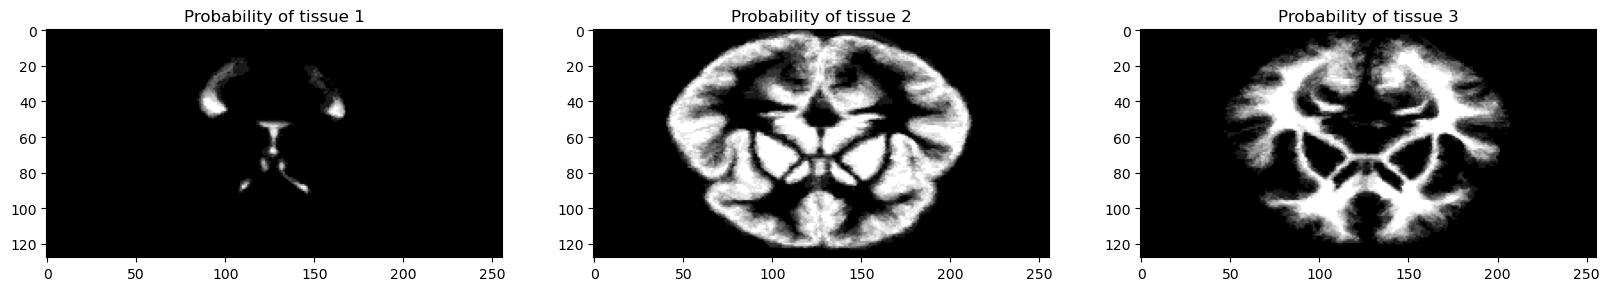

In [10]:
slice = 130
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
for k in range(1,4):
    axs[k-1].imshow(atlas[k-1][slice], cmap='gray')
    axs[k-1].set_title(f'Probability of tissue {k}')

In [24]:
# save atlasses
# save the array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)

for v in range(len(im_val_data.IDs)):
    list_per_each_val=[]
    id_val = im_val_data.IDs[v]
    paths= im_val_data.im_paths()

    fixed_path = repo_path / paths[v]
    fixed_path = str(fixed_path)
    csf_atlas = atlas[0] #Save CSF volume
    wm_atlas = atlas[1] #Save WM volume
    gm_atlas = atlas[2] #Save GM volume
    save_as_nifti(csf_atlas, str(repo_path / 'data'/'atlas_results'/f'csf_atlas_{id_val}.nii.gz'), fixed_path)
    save_as_nifti(wm_atlas, str(repo_path / 'data'/'atlas_results'/f'wm_atlas_{id_val}.nii.gz'), fixed_path)
    save_as_nifti(gm_atlas, str(repo_path / 'data'/'atlas_results'/f'gm_atlas_{id_val}.nii.gz'), fixed_path)

## Segmentation using Atlas 

In [27]:
def get_segmentations():
    for i in range(len(im_val_data.IDs)):
        id_val = im_val_data.IDs[i]
        pat = patient(id_val, im_val_data)

        fixed_path = str(pat.im_path)
        fixed_shape = utils.getArrayfromPath(fixed_path).shape

        prop_labels = np.zeros(shape=(3,)+ fixed_shape)
        for i, tissue in enumerate(['csf', 'wm', 'gm']):
            prop_labels[i] = utils.getArrayfromPath(str(repo_path / 'data'/'atlas_results'/f'{tissue}_atlas_{id_val}.nii.gz'), dtype=float)

        #Get segmentation from propagated labels
        im_seg = np.argmax(prop_labels, axis=0) + 1 #max argument and adding one
        #get mask from original image to remove the regions outside of the tissue
        mask = pat.im(format='np', preprocess=False)>0
        im_seg = im_seg * mask #apply mask to segmentation
        plt.imshow(im_seg[135,:,:], cmap='gray')

        # save the segmentation as a nifti image
        save_as_nifti(im_seg, str(repo_path / 'data'/'atlas_results'/f'segmentation_{id_val}.nii.gz'), fixed_path)

        print(f'The segmentation is for image {id_val}')
        #get dice for each tissue
        for l in range(1,4):
            dice_s = utils.dice_score(im_seg==l, pat.labels(format='np')==l)
            print(f'The dice score for tissue {l} is: {dice_s} ')

The segmentation is for image 11
The dice score for tissue 1 is: 0.7453180132090835 
The dice score for tissue 2 is: 0.8279214698905489 
The dice score for tissue 3 is: 0.8095216148268628 
The segmentation is for image 12
The dice score for tissue 1 is: 0.2902200912714459 
The dice score for tissue 2 is: 0.7528853315085631 
The dice score for tissue 3 is: 0.6766113998185268 
The segmentation is for image 13
The dice score for tissue 1 is: 0.12115592306937066 
The dice score for tissue 2 is: 0.7953702002572111 
The dice score for tissue 3 is: 0.6717089274612604 
The segmentation is for image 14
The dice score for tissue 1 is: 0.08637501455349866 
The dice score for tissue 2 is: 0.7609456211765788 
The dice score for tissue 3 is: 0.6687502081851899 
The segmentation is for image 17
The dice score for tissue 1 is: 0.016924716113612147 
The dice score for tissue 2 is: 0.5729607558560281 
The dice score for tissue 3 is: 0.4810955694631022 


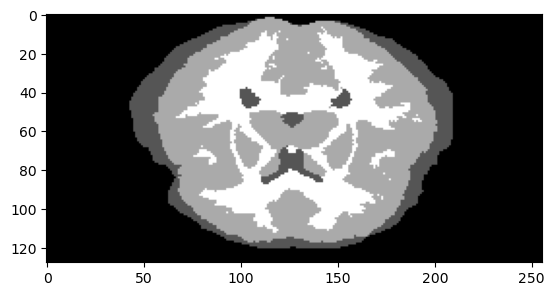

In [28]:
get_segmentations()